In [2]:
import pandas as pd
import numpy as np
import datetime

import networkx as nx
from matplotlib import pyplot as plt

In [3]:
# Load Data
trip_DF = pd.read_csv('D:/Users/nickb/PycharmProjectsD/TaxiProject/data/yellow_tripdata_2019-01.csv')

In [4]:
# Convert timestamps to Datetime objects
print(trip_DF.columns)
trip_DF["tpep_pickup_datetime"] = pd.to_datetime(trip_DF["tpep_pickup_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
trip_DF["tpep_dropoff_datetime"] = pd.to_datetime(trip_DF["tpep_dropoff_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')


In [5]:
# restrict date range
small_DF = trip_DF[(trip_DF["tpep_pickup_datetime"] >= datetime.datetime(2019, 1, 1, 5, 50, 0)) &
                  (trip_DF["tpep_pickup_datetime"] < datetime.datetime(2019, 1, 1, 6, 00, 0))]
locations = set(small_DF["PULocationID"].values).union(set(small_DF["DOLocationID"].values))
print("Num Locations:", len(locations))
print("Num Rides:", len(small_DF))

# combine locations with same PU and DO
# the "agg" function controls the edge feature used -- eg: "count", "mean", "max", ...
grouped = small_DF.groupby(["PULocationID", "DOLocationID"]).agg({'fare_amount': ['mean'], 'passenger_count': ['mean']})
grouped.columns = ["fare_amount", "passenger_count"]
grouped.reset_index()

Num Locations: 147
Num Rides: 475


,PULocationID,DOLocationID,fare_amount,passenger_count
0,1,1,85.000000,1.000000
1,4,178,32.000000,1.000000
2,7,7,5.000000,1.000000
3,7,146,5.000000,1.000000
4,7,223,9.000000,1.000000
5,7,226,8.500000,1.000000
6,10,262,52.000000,1.000000
7,17,61,5.500000,1.000000
8,24,244,13.000000,1.000000
9,36,74,32.000000,1.000000


In [6]:
# Iterate through grouped rows to construct ADJ matrix
adj_matrix = np.zeros((max(locations)+1, max(locations)+1))

for index, data in grouped.iterrows():
    adj_matrix[index] = data[0]
    
adj_matrix

# Construct NetworkX graph
G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)


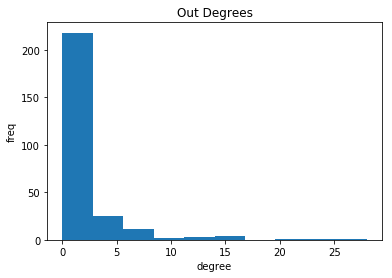

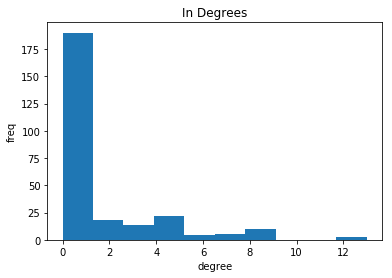

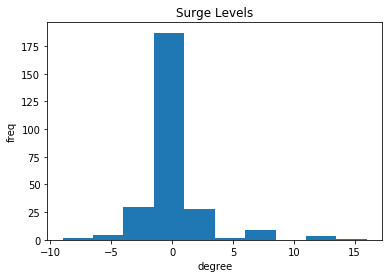

In [15]:
out_degree_sequence = dict(G.out_degree())

plt.hist(out_degree_sequence.values())
plt.title("Out Degrees")
plt.ylabel("freq")
plt.xlabel("degree")
plt.show()

in_degree_sequence = dict(G.in_degree())

plt.hist(in_degree_sequence.values())
plt.title("In Degrees")
plt.ylabel("freq")
plt.xlabel("degree")
plt.show()

surge_level = {key: G.out_degree()[key] - G.in_degree()[key] for key in dict(G.out_degree())}

plt.hist(surge_level.values())
plt.title("Surge Levels")
plt.ylabel("freq")
plt.xlabel("degree")
plt.show()

In [20]:
edge_weights = nx.get_edge_attributes(G,'weight')
sparse_edges = [edge for edge in edge_weights if edge_weights[edge] > 20]
H = G.edge_subgraph(sparse_edges)

h_surge_level = {key: H.out_degree()[key] - H.in_degree()[key] for key in dict(H.out_degree())}

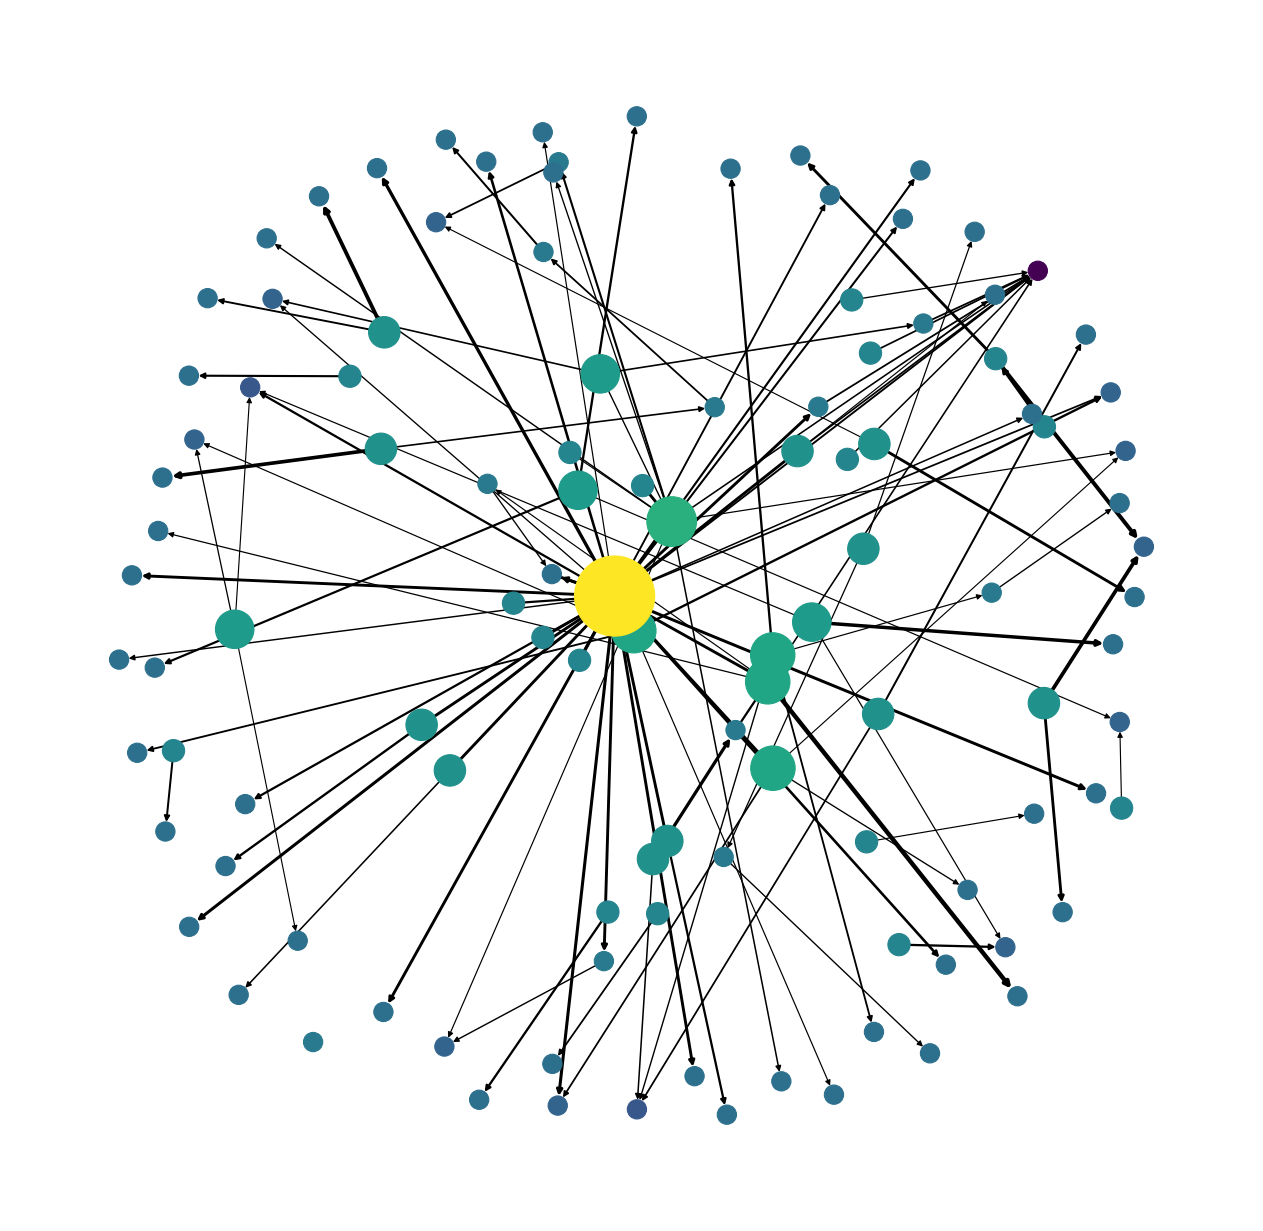

In [55]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(H, k=0.9)
size_values = [max(300, val*400) for val in list(h_surge_level.values())]
nx.draw_networkx_nodes(H,pos, node_color=list(h_surge_level.values()), node_size=size_values)
edge_widths = [max(1, val/20) for val in list(nx.get_edge_attributes(H,'weight').values())]
nx.draw_networkx_edges(H,pos, width=edge_widths)
# nx.draw_networkx_labels(H,pos, font_weight="bold", font_size=16)

plt.savefig("D:/Users/nickb/PycharmProjectsD/TaxiProject/figures/surge_5_50.png")
plt.show()

[85.0,
 32.0,
 24.5,
 52.0,
 28.0,
 71.0,
 52.0,
 52.0,
 32.0,
 32.0,
 40.28,
 24.0,
 35.0,
 52.0,
 36.0,
 37.5,
 26.0,
 27.5,
 52.0,
 28.5,
 22.0,
 24.0,
 21.5,
 32.04,
 47.5,
 39.5,
 42.0,
 21.5,
 34.0,
 68.5,
 24.5,
 42.5,
 21.5,
 21.5,
 33.5,
 24.5,
 29.5,
 29.5,
 22.0,
 62.5,
 22.0,
 29.5,
 65.5,
 25.0,
 41.5,
 33.0,
 21.5,
 31.5,
 36.0,
 38.0,
 24.0,
 52.0,
 38.0,
 55.0,
 21.0,
 52.0,
 54.5,
 53.5,
 34.0,
 21.5,
 31.5,
 23.75,
 26.0,
 52.0,
 33.75,
 41.0,
 47.0,
 46.5,
 52.0,
 36.5,
 52.0,
 59.5,
 40.5,
 52.0,
 52.0,
 27.5,
 52.0,
 36.0,
 40.5,
 52.0,
 52.0,
 30.5,
 20.5,
 51.5,
 23.0,
 22.5,
 42.5,
 52.0,
 67.0,
 51.0,
 31.5,
 24.0,
 52.0,
 20.5,
 20.5,
 20.5,
 23.0,
 25.5,
 39.5,
 31.0,
 41.0,
 52.0,
 21.0,
 79.5,
 21.0,
 52.0,
 29.0,
 22.5,
 41.5,
 58.0,
 27.5,
 27.0,
 32.0,
 20.5,
 21.0]